### gmm(em) => vae(neural)

开始训练VAE...
Epoch 10/150, 平均损失: 4.0679(1.8778, 2.1901)
Epoch 20/150, 平均损失: 3.0485(1.2596, 1.7889)
Epoch 30/150, 平均损失: 2.7342(1.0680, 1.6662)
Epoch 40/150, 平均损失: 2.6099(1.0284, 1.5815)
Epoch 50/150, 平均损失: 2.5415(0.9813, 1.5602)
Epoch 60/150, 平均损失: 2.5071(0.9887, 1.5184)
Epoch 70/150, 平均损失: 2.3964(0.9446, 1.4518)
Epoch 80/150, 平均损失: 2.3864(0.9476, 1.4388)
Epoch 90/150, 平均损失: 2.3686(0.9196, 1.4490)
Epoch 100/150, 平均损失: 2.3587(0.8688, 1.4899)
Epoch 110/150, 平均损失: 2.3302(0.9181, 1.4121)
Epoch 120/150, 平均损失: 2.3316(0.8925, 1.4391)
Epoch 130/150, 平均损失: 2.3451(0.9312, 1.4139)
Epoch 140/150, 平均损失: 2.3473(0.9143, 1.4330)
Epoch 150/150, 平均损失: 2.3251(0.8884, 1.4367)
训练完成!
正在生成可视化图表...


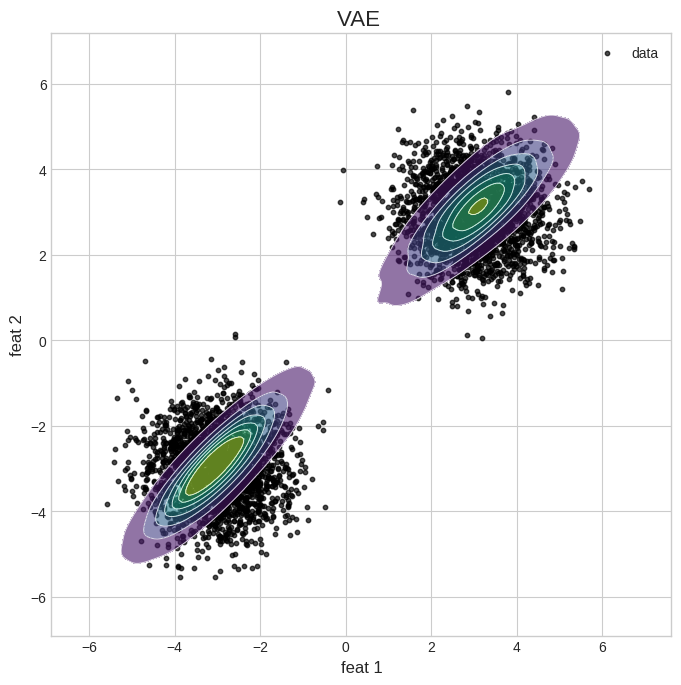

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs

# --- 1. 配置参数 (Configuration) ---
INPUT_DIM = 2
LATENT_DIM = 4
HIDDEN_DIM = 128
NUM_SAMPLES = 5000
BATCH_SIZE = 1024
EPOCHS = 150
LEARNING_RATE = 1e-3
BETA = 1.0 # KL散度的权重

# --- 2. 生成双峰数据 (Generate Bimodal Data) ---
# 使用 scikit-learn 的 make_blobs 生成聚类数据
centers = [(-3, -3), (3, 3)]
X, y = make_blobs(n_samples=NUM_SAMPLES, centers=centers, cluster_std=0.8, random_state=42)

# 转换成 PyTorch Tensor
X_tensor = torch.from_numpy(X).float()
dataset = TensorDataset(X_tensor)
data_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# --- 3. 定义VAE模型 (Define VAE Model) ---
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()
        
        # 编码器 (Encoder)
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim, latent_dim)
        
        # 解码器 (Decoder)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )

    def reparameterize(self, mu, log_var):
        """
        重参数化技巧：z = mu + std * epsilon
        """
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        return mu + std * epsilon

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        
        z = self.reparameterize(mu, log_var)
        
        recon_x = self.decoder(z)
        
        return recon_x, mu, log_var

# --- 4. 定义损失函数 (Define Loss Function) ---
def vae_loss_function(recon_x, x, mu, log_var, beta=1.0):
    # 重建损失 (Reconstruction Loss)
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    
    # KL散度 (KL Divergence)
    # D_KL(Q(z|X) || P(z)) where P(z) is N(0, I)
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return recon_loss + beta * kl_div, recon_loss, kl_div

# --- 5. 训练模型 (Train the Model) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("开始训练VAE...")
model.train()
for epoch in range(EPOCHS):
    total_loss = 0
    total_recon_loss = 0
    total_kl_div = 0
    for batch_idx, (data,) in enumerate(data_loader):
        data = data.to(device)
        
        optimizer.zero_grad()
        
        recon_batch, mu, log_var = model(data)
        loss, recon_loss, kl_div = vae_loss_function(recon_batch, data, mu, log_var, BETA)
        
        loss.backward()
        total_loss += loss.item()
        total_recon_loss += recon_loss.item()
        total_kl_div += kl_div.item()
        
        optimizer.step()
        
    avg_loss = total_loss / len(data_loader.dataset)
    avg_recon_loss = total_recon_loss / len(data_loader.dataset)
    avg_kl_div = total_kl_div / len(data_loader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, 平均损失: {avg_loss:.4f}({avg_recon_loss:.4f}, {avg_kl_div:.4f})")

print("训练完成!")

# --- 6. 可视化结果 (Visualize Results) ---
print("正在生成可视化图表...")
model.eval()

# 设置绘图风格
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(8, 8))

# a. 绘制原始数据点
ax.scatter(X[:, 0], X[:, 1], c='black', s=10, alpha=0.7, label='data')

# b. 从潜在空间采样，通过解码器生成新的数据点
# with torch.no_grad():
#     # 从标准正态分布中采样
#     z_samples = torch.randn(NUM_SAMPLES, LATENT_DIM).to(device)
#     generated_x = model.decoder(z_samples).cpu().numpy()

# c. 使用KDE绘制生成数据分布的等高线
# sns.kdeplot(
#     x=generated_x[:, 0],
#     y=generated_x[:, 1],
#     ax=ax,
#     fill=True,
#     cmap="viridis",
#     levels=8,
#     alpha=0.6,
#     label='VAE distribution'
# )

# # d. 绘制等高线轮廓
# sns.kdeplot(
#     x=generated_x[:, 0],
#     y=generated_x[:, 1],
#     ax=ax,
#     colors='white',
#     linewidths=0.7,
#     levels=8,
#     alpha=0.8
# )

with torch.no_grad():
    reconstructed_x, _, _ = model(X_tensor.to(device))
    reconstructed_x = reconstructed_x.cpu().numpy()

# c. 使用KDE绘制生成数据分布的等高线
sns.kdeplot(
    x=reconstructed_x[:, 0],
    y=reconstructed_x[:, 1],
    ax=ax,
    fill=True,
    cmap="viridis",
    levels=8,
    alpha=0.6,
    label='VAE distribution'
)

# d. 绘制等高线轮廓
sns.kdeplot(
    x=reconstructed_x[:, 0],
    y=reconstructed_x[:, 1],
    ax=ax,
    colors='white',
    linewidths=0.7,
    levels=8,
    alpha=0.8
)

ax.set_title("VAE ", fontsize=16)
ax.set_xlabel("feat 1", fontsize=12)
ax.set_ylabel("feat 2", fontsize=12)
ax.legend()
ax.set_aspect('equal', adjustable='box')

-------

- VAE 可以被理解为 EM 算法在处理复杂模型（尤其是深度神经网络）时的一种近似和推广。它们的核心思想一脉相承，都是为了解决含隐变量模型的最大似然估计问题。
- 无论是 EM 还是 VAE，它们的目标都是最大化观测数据的对数似然 $\log p(x)$。当模型包含隐变量 $z$ 时，这个似然函数因为需要对 $z$ 进行积分（$\log ∫ p(x,z)dz$）而变得难以直接优化。
    - 为了解决这个问题，两者都引入了一个共同的工具——证据下界（Evidence Lower Bound, ELBO）。
    - ELBO 是 $\log p(x; θ)$ 的一个下界。

| 特征 | EM 算法 (Expectation-Maximization) | VAE (Variational Autoencoder) |
| :--- | :--- | :--- |
| **核心目标** | 在有隐变量的情况下，最大化数据的对数似然 `log p(x)`。 | 同样是最大化 `log p(x)`，但实际操作是最大化其下界 (ELBO)。 |
| **隐变量 `z`** | 通常是低维、离散的（如：聚类的类别）。 | 通常是高维、连续的（如：图像的特征向量）。 |
| **E-Step (推断)** | **精确计算**后验概率 `p(z\|x)`。要求模型简单，后验可解。 | 用一个**编码器网络 `q(z\|x)`** 来**近似**不可解的后验 `p(z\|x)`。 |
| **M-Step (学习)** | 根据 E-step 的结果，用**解析解或简单优化**来更新模型参数 `p(x\|z)`。 | 用一个**解码器网络**来代表 `p(x\|z)`，通过**梯度下降**更新其参数。 |
| **执行方式** | E-step 和 M-step **交替迭代**，直到收敛。 | 编码器和解码器**联合训练**，通过梯度下降进行端到端优化。 |
| **本质** | 一种用于含有隐变量的参数估计的**迭代算法**。 | 一种用于复杂数据建模和生成的**深度生成模型**。 |